# pullenti-client

Предполагается, что на порту 8080 работает PullentiServer. Пример команды для запуска `docker run -it --rm -p 8080:8080 pullenti/pullenti-server`, подробнее в [репозитории PullentiServer](https://github.com/pullenti/PullentiServer).

In [1]:
from pullenti_client import Client

client = Client('localhost', 8080)

In [2]:
text = 'В США прядь волос третьего президента Соединенных Штатов Томаса Джефферсона продали на аукционе в Техасе за 6,9 тысячи долларов, передает Life. Локоны бывшего лидера США ушли с молотка почти через 190 лет после его смерти. Их покупатель пожелал остаться неизвестным. Перед началом аукциона волосы Джефферсона оценивали в 3 тысячи долларов. В январе 2015 года прядь волос 16-го президента США Авраама Линкольна продали за 25 тысяч долларов на аукционе в Далласе. Выставленную на аукцион прядь срезал начальник медицинской службы Армии США Джозеф Барнс после того, как Линкольн был застрелен 14 апреля 1865 года Джоном Бутом. Томас Джефферсон был автором Декларации независимости США и третьим президентом страны (1801-1809 годы). Авраам Линкольн — первый президент от Республиканской партии США в 1861-1865 годах, национальный герой США.'
result = client(text)

`result` содержит два поля:
- `text` — обработанный текст
- `matches` — список подстрок с найденными сущностями

`match` состоит из:
- `referent` — структурированное описание сущности, например, для "в январе 2015 года" это `month: 1, year: 2015`
- `span` — начало, конец подстроки
- `children` — вложенные сущности, например, в "президент Соединенных Штатов Томас Джефферсон" вложены должность "президент" и место "США". Рекурсивно обойти всех `children` удобно методом `walk`:

In [3]:
# pip install ipymarkup
from ipymarkup import show_span_ascii_markup as show_markup

spans = []
for match in result.walk():
    start, stop = match.span
    label = match.referent.label
    spans.append([start, stop, label])
show_markup(result.text, spans)

В США прядь волос третьего президента Соединенных Штатов Томаса 
  GEO             PERSON────────────────────────────────────────
                  PERSONPROPERTY────────────────────────        
                                      GEO───────────────        
Джефферсона продали на аукционе в Техасе за 6,9 тысячи долларов, 
───────────                       GEO───                         
передает Life. Локоны бывшего лидера США ушли с молотка почти через 
         ORGA         PERSONPROPERTY────                            
                                     GEO                            
190 лет после его смерти. Их покупатель пожелал остаться неизвестным. 
Перед началом аукциона волосы Джефферсона оценивали в 3 тысячи 
                              PERSON─────                      
долларов. В январе 2015 года прядь волос 16-го президента США Авраама 
                                               PERSON─────────────────
                                               PERSONPROPERT

У `referent` есть два поля:
- `label` — например, `'PERSON'`, `'PERSONPROPERTY'`, `'DATE'`, `'DATERANGE'`. По `label` удобно отбирать нужные сущности
- `slots` — пары `key`, `value` с аттрибутами. Некоторые пары могут повторяться например `('NAME', 'США')`, `('NAME', 'СОЕДИНЕННЫЕ ШТАТЫ')`, поэтому `slots` спиок, а не словарь: 

In [4]:
match = result.matches[1]
referent = match.referent
referent

Referent(
    label='PERSON',
    slots=[Slot(
         key='SEX',
         value='MALE'
     ),
     Slot(
         key='LASTNAME',
         value='ТОМАС'
     ),
     Slot(
         key='FIRSTNAME',
         value='ДЖЕФФЕРСОН'
     ),
     Slot(
         key='ATTRIBUTE',
         value=Referent(
             label='PERSONPROPERTY',
             slots=[Slot(
                  key='REF',
                  value=Referent(
                      label='GEO',
                      slots=[Slot(
                           key='ALPHA2',
                           value='US'
                       ),
                       Slot(
                           key='NAME',
                           value='США'
                       ),
                       Slot(
                           key='NAME',
                           value='СОЕДИНЕННЫЕ ШТАТЫ'
                       ),
                       Slot(
                           key='NAME',
                           value='СОЕДИНЕННЫЕ ШТАТЫ 

В `value` иммет тип `str` ("ДЖЕФФЕРСОН", "президент", "US") или `referent`. Получается, что `referent` можно представить в виде графа:

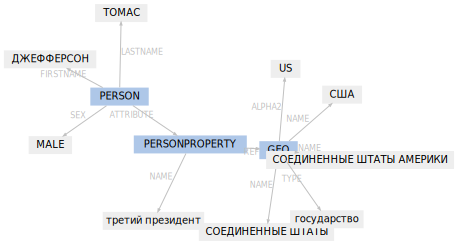

In [5]:
# install graphviz (macos: brew install graphviz)
referent.graph